In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mlutils
%matplotlib inline
import pandas as pd
print tf.__version__

1.9.0


/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Download, fix and inspect data

In [2]:
import os
!mkdir -p data
if not os.path.exists("data/adult.data"):
    !wget -c -nc https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -P data
    with open("data/adult.data", "r") as f:
        lines = f.readlines()
        lines = [i for i in lines if len(i.replace("\n", ""))>0]
    with open("data/adult.data", "w") as f:
        f.writelines(lines) 
    
if not os.path.exists("data/adult.test"):        
    !wget -c -nc https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -P data
    with open("data/adult.test", "r") as f:
        lines = f.readlines()
        lines = [i for i in lines if len(i.replace("\n", ""))>0]
    with open("data/adult.test", "w") as f:
        f.writelines(lines[1:]) 


In [3]:
!head -5 data/adult.data

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K


In [4]:
CSV_COLUMNS = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
               'marital_status', 'occupation', 'relationship', 'race', 'gender',
               'capital_gain', 'capital_loss', 'hours_per_week',
               'native_country', 'income_bracket']

CSV_DEFAULTS = [[0], [''], [0], [''], [0], [''], [''], [''], [''], [''],[0], [0], [0], [''], ['']]

census= pd.read_csv("data/adult.data", names = CSV_COLUMNS)
print census.shape
census.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocesado

Normalmente tendríamos que cargar los datos en memoria, limpiar y procesarlos y luego entregarlos a alguna herramienta de ML (i.e. `sklearn`). Fíjate que, en TF, creamos input pipelines que se integran con el proceso de entrenamiento y validación.

Vamos a empezar con una tarea de clasificación muy sencilla:

- la variable objetivo es `income_braket` (que tendremos que transformar a un cierto valor numérico y categórico)
- usaremos las variables de entrada `age` (numérica), y `occupation` (que también tendremos que transformar)

Usamos **pandas** ahora para inspeccionar el dataset, pero nuestros pipelines **nacerán desde los ficheros de texto**.

In [5]:
d = census[["age", "occupation", "income_bracket"]].dropna()
d.head()

,age,occupation,income_bracket
0,39,Adm-clerical,<=50K
1,50,Exec-managerial,<=50K
2,38,Handlers-cleaners,<=50K
3,53,Handlers-cleaners,<=50K
4,28,Prof-specialty,<=50K


In [6]:
d.age.value_counts()

36    898
31    888
34    886
23    877
35    876
33    875
28    867
30    861
37    858
25    841
27    835
32    828
38    827
39    816
29    813
41    808
24    798
40    794
26    785
42    780
43    770
22    765
20    753
46    737
45    734
44    724
21    720
19    712
47    708
50    602
     ... 
60    312
61    300
62    258
63    230
64    208
65    178
67    151
66    150
68    120
69    108
70     89
71     72
72     67
73     64
74     51
76     46
75     45
90     43
77     29
78     23
80     22
79     22
81     20
82     12
84     10
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64

In [7]:
d.occupation.value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [8]:
d.income_bracket.value_counts()

 <=50K    24720
 >50K      7841
Name: income_bracket, dtype: int64

In [9]:
d.income_bracket.value_counts()/len(d)

 <=50K    0.75919
 >50K     0.24081
Name: income_bracket, dtype: float64

In [10]:
d.shape, d.dropna().shape

((32561, 3), (32561, 3))

### creamos las funciones para construir nuestro `input pipeline`

observa como inicialmente TF nos entrega los contenidos de un fichero de texto

In [11]:

dataset = tf.data.TextLineDataset("data/adult.data")
dataset = dataset.batch(10)
features = dataset.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    print sess.run(features)


['39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K'
 '50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K'
 '38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K'
 '53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K'
 '28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K'
 '37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K'
 '49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K'
 '52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, U

y si hacemos un parsing básico, nos las entrega como un diccionario

In [12]:
def parse_csv(rows_string_tensor):
    columns = tf.decode_csv(rows_string_tensor, record_defaults=CSV_DEFAULTS)
    return dict(zip(CSV_COLUMNS, columns))

dataset = tf.data.TextLineDataset("data/adult.data")
dataset = dataset.batch(10)
dataset = dataset.map(parse_csv)    
features = dataset.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    print sess.run(features)

{'hours_per_week': array([40, 13, 40, 40, 40, 40, 16, 45, 50, 40], dtype=int32), 'workclass': array([' State-gov', ' Self-emp-not-inc', ' Private', ' Private',
       ' Private', ' Private', ' Private', ' Self-emp-not-inc',
       ' Private', ' Private'], dtype=object), 'relationship': array([' Not-in-family', ' Husband', ' Not-in-family', ' Husband',
       ' Wife', ' Wife', ' Not-in-family', ' Husband', ' Not-in-family',
       ' Husband'], dtype=object), 'gender': array([' Male', ' Male', ' Male', ' Male', ' Female', ' Female',
       ' Female', ' Male', ' Female', ' Male'], dtype=object), 'age': array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42], dtype=int32), 'marital_status': array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-civ-spouse', ' Married-civ-spouse',
       ' Married-civ-spouse', ' Married-spouse-absent',
       ' Married-civ-spouse', ' Never-married', ' Married-civ-spouse'],
      dtype=object), 'race': array([' White', ' White', ' White', ' Bla

hacemos ahora el **pipeline completo** decidiendo cual es la columna a predecir, cómo se transforma y seleccionando algunas columnas

In [13]:
labels = list(np.unique(d.income_bracket))
print labels
occupations = list(np.unique(d.occupation))
print occupations

[' <=50K', ' >50K']
[' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving']


In [14]:
def parse_csv(rows_string_tensor, use_features):
    columns = tf.decode_csv(rows_string_tensor, record_defaults=CSV_DEFAULTS)
    features = dict(zip(CSV_COLUMNS, columns))

    # graph to deal with casuistics of label string
    ib = features["income_bracket"]
    zero = lambda: tf.constant(0, dtype=tf.float32)
    one  = lambda: tf.constant(1, dtype=tf.float32)
    features["income_bracket"] = tf.cond(tf.equal(ib, " >50K"), one, 
                                         lambda: tf.cond(tf.equal(ib, " >50K."), one,
                                         lambda: tf.cond(tf.equal(ib, " <=50K"), zero, 
                                         lambda: tf.cond(tf.equal(ib, " <=50K."), zero,
                                         lambda: tf.constant(-1, dtype=tf.float32)))))
    
    label = features.pop("income_bracket")
    
    return {k:v for k,v in features.iteritems() if k in use_features}, label

def get_dataset(filename, repeat, batch_size, shuffle):
    use_features = ["age", "occupation", "income_bracket"]
    
    dataset = tf.data.TextLineDataset(filename)
    dataset = dataset.repeat(repeat)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=300)
    dataset = dataset.map(lambda x: parse_csv(x, use_features))    
    dataset = dataset.batch(batch_size)
    return dataset

def get_features_defs():
    c1 = tf.feature_column.numeric_column("age")
    c2 = tf.feature_column.categorical_column_with_vocabulary_list('occupation', occupations)
    c2 = tf.feature_column.indicator_column(c2)
    return [c1,c2]

def make_data_iterator(filename, repeat, batch_size, shuffle=True):
    
    dataset = get_dataset(filename, repeat, batch_size, shuffle)
    features_defs = get_features_defs()
    
    features, label = dataset.make_one_shot_iterator().get_next()
    
    next_X = tf.feature_column.input_layer(features, features_defs)
    next_y = tf.reshape(label, (-1,1))
    
    return next_X, next_y

observa cómo transforma el input pipeline los datos de entrada

In [15]:
tf.reset_default_graph()

features, label = make_data_iterator("data/adult.data", repeat=1, batch_size=10, shuffle=False)
with tf.Session() as sess:
    tf.tables_initializer().run()
    f,l = sess.run([features, label])

In [16]:
print f

[[39.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [50.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [38.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [53.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [28.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [37.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [49.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [52.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [31.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [42.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [17]:
print l

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [18]:
!head -3 data/adult.data

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K


## Ejercicio 1. Ejecución del modelo y cálculo de métricas

Usaremos el modelo de clasificación lineal desarrollado en el taller anterior. Lo tienes implementado en 

- `mlutils.logreg_model`
- `mlutils.optimizer`
- `mlutils.plot_hists`

en este taller tendrás que 

- inyectar datos para entrenamiento con la función anterior desde el fichero `data/adult.data` con 2 repeticiones, batch_size de 20 y con shuffle.
- inyectar datos para test con la función anterior desde el fichero `data/adult.test` con infinitas repeticiones (-1), batch_size de 20 y sin shuffle.


In [24]:
reload(mlutils)
tf.reset_default_graph()

train_input_iterator = lambda: make_data_iterator("data/adult.data", repeat=2, batch_size=20, shuffle=True)
test_input_iterator  = lambda: make_data_iterator("data/adult.test", repeat=-1, batch_size=20, shuffle=False)

syms = mlutils.logreg_model(train_input_iterator=train_input_iterator, test_input_iterator=test_input_iterator)
y_hat, prediction, accuracy, loss, params, test_mode = syms

step       3200  train_acc 0.70 test_acc 0.85                 
finished iteration


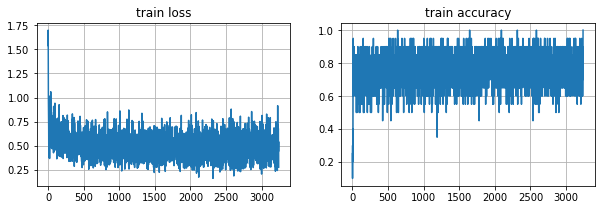

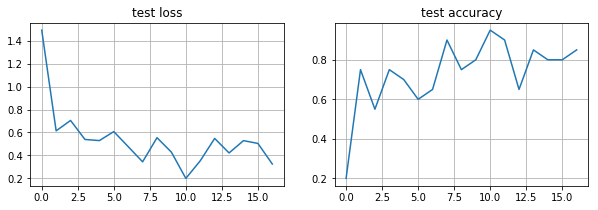

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=.01).minimize(loss)
train_hist, test_hist, nparams = mlutils.optimize(optimizer, loss, accuracy, params, test_mode, 
                                                  log_period=200, name="census")
mlutils.plot_hists(train_hist, test_hist)

## Ejercicio 2: predicción y métricas

obtenemos las predicciones. observa que al cambiar la función `test_input_iterator` tenemos que construir el grafo computacional completo de nuevo.

Completa las funciones `obtain_predictions` y `obtain_first_batch`

In [26]:
def obtain_predictions(nparams, input_iterator):
    tf.reset_default_graph()
    syms = mlutils.logreg_model(train_input_iterator=input_iterator, test_input_iterator=input_iterator)
    _, prediction, _, _, params, test_mode = syms

    fd = {k:v for k,v in zip(params+[test_mode], nparams[0]+[True])}
    with tf.Session() as sess:
        tf.global_variables_initializer().run()    
        tf.tables_initializer().run()
        preds = sess.run(prediction, feed_dict=fd)
    print preds.shape
    return preds[:,0]

def obtain_first_batch(input_iterator):
    tf.reset_default_graph()
    
    nx,ny = input_iterator()

    with tf.Session() as sess:
        tf.tables_initializer().run()    
        tf.global_variables_initializer().run()
        nnx, nny = sess.run([nx, ny])
        
    return nnx, nny[:,0]#[0].reshape(-1,1)[:,0]
        
def get_scores(nparams, input_iterator):

    preds = obtain_predictions(nparams, input_iterator)    
    print preds.shape
    _, nny = obtain_first_batch(input_iterator) 
    print "shapes", preds.shape, nny.shape
    print "true distribution"
    print pd.Series(nny).value_counts()
    print "prediction distribution"
    print pd.Series(preds).value_counts()
    
    print "accuracy %.2f"%np.mean(preds==nny)
    print "tpr      %.2f"%np.mean(preds[nny==1]==1)
    print "tnr      %.2f"%np.mean(preds[nny==0]==0)
    print "fpr      %.2f"%np.mean(preds[nny==0]==1)
    print "fnr      %.2f"%np.mean(preds[nny==1]==0)

In [27]:
test_input_iterator  = lambda: make_data_iterator("data/adult.test", repeat=1, batch_size=1600, shuffle=True)
get_scores( nparams, test_input_iterator)

(1600, 1)
(1600,)
shapes (1600,) (1600,)
true distribution
0.0    1220
1.0     380
dtype: int64
prediction distribution
0.0    1573
1.0      27
dtype: int64
accuracy 0.75
tpr      0.01
tnr      0.98
fpr      0.02
fnr      0.99


In [28]:
train_input_iterator  = lambda: make_data_iterator("data/adult.data", repeat=1, batch_size=3200, shuffle=True)
get_scores( nparams, train_input_iterator)

(3200, 1)
(3200,)
shapes (3200,) (3200,)
true distribution
0.0    2406
1.0     794
dtype: int64
prediction distribution
0.0    3155
1.0      45
dtype: int64
accuracy 0.75
tpr      0.02
tnr      0.99
fpr      0.01
fnr      0.98


## Ejercicio 3. Incorporación y preprocesado de _features_

- convierte `age` en una columna `bucketized` con los siguientes límites: `[0,20,40,80,100]`
- convierte `occupation` en un embedding de 10 dimensiones.
- añade la columns `native_country` como un `categorical_column_with_hash_bucket` de tamaño 10
- añade la columna `education` como un embedding de 10 dimensiones

con esto, la clasificación global no mejorará mucho, pero es probable que el desempeño entre las clases esté más equilibrado. En la práctica ML es así, a base de muchas pequeñas victorias!!!

In [29]:
education = census.education.unique()
print education

workclass = census.workclass.unique()
print workclass

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


In [30]:
def get_extended_dataset(filename, repeat, batch_size, shuffle):
    use_features = ["age", "occupation", "education", "native_country", "income_bracket"]
    
    dataset = tf.data.TextLineDataset(filename)
    dataset = dataset.repeat(repeat)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=300)
    dataset = dataset.map(lambda x: parse_csv(x, use_features))    
    dataset = dataset.batch(batch_size)
    return dataset

def get_extended_features_defs():
    c_age = tf.feature_column.numeric_column("age")

    c_bage = tf.feature_column.bucketized_column(c_age, boundaries=[0,20,40,80,100])
    
    c_occ = tf.feature_column.categorical_column_with_vocabulary_list('occupation', occupations)
    c_iocc = tf.feature_column.embedding_column(c_occ, dimension=10)
    
    c_edu = tf.feature_column.categorical_column_with_vocabulary_list('education', education)
    c_iedu = tf.feature_column.embedding_column(c_edu, dimension=10)
    
    
    c_cou = tf.feature_column.categorical_column_with_hash_bucket(
        'native_country', hash_bucket_size=10, dtype=tf.string)
    c_icou = tf.feature_column.indicator_column(c_cou)    
    return [c_bage, c_iocc, c_iedu, c_icou]
    
def make_extended_data_iterator(filename, repeat, batch_size, shuffle=True):

    dataset = get_extended_dataset(filename, repeat, batch_size, shuffle)
    features_defs = get_extended_features_defs()
    
    features, label = dataset.make_one_shot_iterator().get_next()
    
    next_X = tf.feature_column.input_layer(features, features_defs)
    next_y = tf.reshape(label, (-1,1))
    
    return next_X, next_y
    



In [31]:
reload(mlutils)
tf.reset_default_graph()

train_input_iterator = lambda: make_extended_data_iterator("data/adult.test", repeat=2, batch_size=50, shuffle=False)

nx,ny = train_input_iterator()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.tables_initializer().run()    
    nnx,nny = sess.run([nx,ny])

print nnx.shape
print nnx[0]
print nnx[:5,0]
print nny[:5]

(50, 36)
[ 0.          0.          1.          0.          0.          0.
  0.16272894  0.06631896 -0.00702208 -0.09091324 -0.57155067  0.35779944
  0.3814835   0.2916009   0.4421563  -0.36885765  0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.         -0.15117104  0.15333918  0.32420895  0.08107826
 -0.15165254 -0.22215192  0.09129518 -0.15286312  0.14851874 -0.09130395]
[0. 0. 0. 0. 0.]
[[0.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [32]:
reload(mlutils)
tf.reset_default_graph()
train_input_iterator = lambda: make_extended_data_iterator("data/adult.data", repeat=2, batch_size=20, shuffle=True)
test_input_iterator  = lambda: make_extended_data_iterator("data/adult.test", repeat=-1, batch_size=20, shuffle=False)

syms = mlutils.logreg_model(train_input_iterator=train_input_iterator,
                            test_input_iterator=test_input_iterator)
y_hat, prediction, accuracy, loss, params, test_mode = syms

optimizer = tf.train.AdamOptimizer(learning_rate=.01).minimize(loss)
train_hist, test_hist, nparams = mlutils.optimize(optimizer, loss, accuracy, params, test_mode, 
                                                  name="census_extended", log_period=200)


step       3200  train_acc 0.70 test_acc 0.50                 
finished iteration


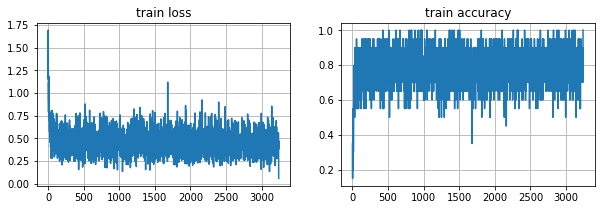

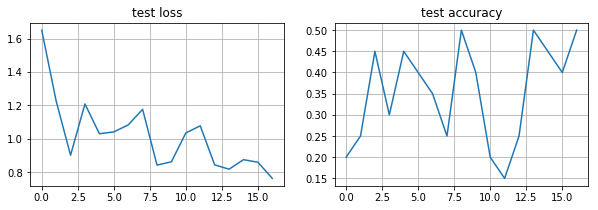

In [33]:
mlutils.plot_hists(train_hist, test_hist)

In [34]:
train_input_iterator  = lambda: make_extended_data_iterator("data/adult.data", repeat=1, batch_size=32000, shuffle=True)
get_scores(nparams, train_input_iterator)

(32000, 1)
(32000,)
shapes (32000,) (32000,)
true distribution
0.0    24286
1.0     7714
dtype: int64
prediction distribution
0.0    17822
1.0    14178
dtype: int64
accuracy 0.53
tpr      0.45
tnr      0.56
fpr      0.44
fnr      0.55


In [35]:
test_input_iterator  = lambda: make_extended_data_iterator("data/adult.test", repeat=1, batch_size=16000, shuffle=True)
get_scores(nparams, test_input_iterator)

(16000, 1)
(16000,)
shapes (16000,) (16000,)
true distribution
0.0    12216
1.0     3784
dtype: int64
prediction distribution
0.0    9832
1.0    6168
dtype: int64
accuracy 0.56
tpr      0.39
tnr      0.62
fpr      0.38
fnr      0.61
